In [1]:
import jax
import jax.numpy as jnp
import optax


import matplotlib.pyplot as plt
import numpy as np


from tqdm import tqdm as tqdm
import pandas as pd


import time

In [2]:
def generate_gaussian_samples(mu, cov, n_samples, seed=0):


    d = mu.shape[0]
    key = jax.random.PRNGKey(seed)
    z = jax.random.normal(key, shape=(n_samples, d))


    L = jnp.linalg.cholesky(cov)
    samples = mu + z @ L.T
    
    
    return samples

In [3]:
def potential_grad(sample, mu, cov):


    eps = 1e-2
    precision = jnp.linalg.inv(cov + eps * jnp.eye(len(mu)))


    return (sample - mu) @ precision

In [4]:
def evolve_langevin(samples, mu, cov, eps=1e-2, n_evolution=100, seed=0):

    
    key = jax.random.PRNGKey(seed)
    evolved_samples = samples

    n_samples = len(samples)


    for i in range(n_evolution):
        key, subkey = jax.random.split(key)
        grad = potential_grad(evolved_samples, mu, cov)
        noise = jax.random.normal(subkey, shape=evolved_samples.shape)
        evolved_samples = evolved_samples - (eps * grad + jnp.sqrt(2 * eps) * noise)
        # evolved_samples = evolved_samples - (1 / n_samples) * (eps * grad + jnp.sqrt(2 * eps) * noise)
        

    return evolved_samples

In [5]:
def compute_moments_disc(samples, evolved_samples):


    mu_1 = jnp.mean(samples, axis=0)
    mu_2 = jnp.mean(evolved_samples, axis=0)


    centered_1 = samples - mu_1
    centered_2 = evolved_samples - mu_2


    cov_1 = centered_1.T @ centered_1 / samples.shape[0]
    cov_2 = centered_2.T @ centered_2 / evolved_samples.shape[0]


    loss_mu = jnp.sum((mu_1 - mu_2) ** 2)
    loss_cov = jnp.sum((cov_1 - cov_2) ** 2)


    return (loss_mu + loss_cov)

In [6]:
def lm_loss(samples, mu, cov):


    evolved_samples = evolve_langevin(samples, mu, cov)


    return compute_moments_disc(samples, evolved_samples)

In [7]:
def lm_optimize_with_tracking(
    samples,
    true_mu,
    true_cov,
    n_epochs=1000,
    base_lr=1e-2,
    seed=10,
    eps=1e-2,
    plot_every=1,
    use_lr_schedule=True
):
    

    n, d = samples.shape


    mu10 = jnp.array([1.0, -1.0, -2.0, -0.5, -.5, 1.0, 1.5, 3.2, -4.2, -0.8])


    cov10 = jnp.array([
        [1.0,  0.8,  0.6,  0.4,  0.2,  0.1,  0.0, -0.1, -0.1, -0.2],
        [0.8,  1.0,  0.7,  0.5,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2],
        [0.6,  0.7,  1.0,  0.6,  0.4,  0.3,  0.2,  0.1,  0.0, -0.1],
        [0.4,  0.5,  0.6,  1.0,  0.5,  0.4,  0.3,  0.2,  0.1,  0.0],
        [0.2,  0.3,  0.4,  0.5,  1.0,  0.5,  0.4,  0.3,  0.2,  0.1],
        [0.1,  0.2,  0.3,  0.4,  0.5,  1.0,  0.6,  0.4,  0.3,  0.2],
        [0.0,  0.1,  0.2,  0.3,  0.4,  0.6,  1.0,  0.7,  0.5,  0.3],
        [-0.1, 0.0,  0.1,  0.2,  0.3,  0.4,  0.7,  1.0,  0.8,  0.6],
        [-0.1, -0.1, 0.0,  0.1,  0.2,  0.3,  0.5,  0.8,  1.0,  0.7],
        [-0.2, -0.2, -0.1, 0.0,  0.1,  0.2,  0.3,  0.6,  0.7,  1.0]
    ])


    mu = jnp.tile(mu10, 5)


    cov = jnp.kron(jnp.eye(5), cov10)


    A = jnp.linalg.cholesky(cov).T


    params = {
        "mu": mu,
        "A": A
    }


    if use_lr_schedule:
        lr_schedule = optax.linear_schedule(
            init_value=1e-2,
            end_value=base_lr,
            transition_steps=500
        )
        optimizer = optax.adam(learning_rate=lr_schedule)
    else:
        optimizer = optax.adam(learning_rate=base_lr)


    opt_state = optimizer.init(params)


    def loss_fn(params, samples):
        mu = params["mu"]
        A = params["A"]
        cov = A.T @ A
        return lm_loss(samples, mu, cov)


    history = {
        "loss": [],
        "mu_l2": [],
        "cov_fro": [],
    }


    for epoch in range(n_epochs):
        loss_val, grads = jax.value_and_grad(loss_fn)(params, samples)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)


        mu_val = params["mu"]
        A_val = params["A"]
        cov_val = A_val.T @ A_val


        history["loss"].append(loss_val)
        history["mu_l2"].append(jnp.linalg.norm(true_mu - mu_val))
        history["cov_fro"].append(jnp.linalg.norm(true_cov - cov_val, ord='fro'))


        if epoch % plot_every == 0 or epoch == n_epochs - 1:
            print(f"epoch {epoch} | loss = {loss_val:.6f}")


    final_mu = params["mu"]
    final_cov = params["A"].T @ params["A"]


    return final_mu, final_cov, history

In [8]:
mu10 = jnp.array([0.0, 1.0, -1.0, 0.5, -0.5, 1.5, -1.5, 0.2, -0.2, 0.8])


cov10 = jnp.array([
    [ 1.0,  0.4,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2, -0.3, -0.4],
    [ 0.4,  1.0,  0.5,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2, -0.3],
    [ 0.3,  0.5,  1.0,  0.4,  0.3,  0.2,  0.1,  0.0, -0.1, -0.2],
    [ 0.2,  0.3,  0.4,  1.0,  0.5,  0.3,  0.2,  0.1,  0.0, -0.1],
    [ 0.1,  0.2,  0.3,  0.5,  1.0,  0.4,  0.3,  0.2,  0.1,  0.0],
    [ 0.0,  0.1,  0.2,  0.3,  0.4,  1.0,  0.5,  0.3,  0.2,  0.1],
    [-0.1,  0.0,  0.1,  0.2,  0.3,  0.5,  1.0,  0.4,  0.3,  0.2],
    [-0.2, -0.1,  0.0,  0.1,  0.2,  0.3,  0.4,  1.0,  0.5,  0.3],
    [-0.3, -0.2, -0.1,  0.0,  0.1,  0.2,  0.3,  0.5,  1.0,  0.4],
    [-0.4, -0.3, -0.2, -0.1,  0.0,  0.1,  0.2,  0.3,  0.4,  1.0]
])


mu = jnp.tile(mu10, 5)


cov = jnp.kron(jnp.eye(5), cov10)

In [9]:
samples = generate_gaussian_samples(mu, cov, n_samples=2000, seed=0)


start_time = time.time()


final_mu, final_cov, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=2000, base_lr=0.1, seed = 0)


end_time = time.time()
elapsed_time = end_time - start_time
round_time = elapsed_time/2000
print(round_time)

epoch 0 | loss = 186.243271
epoch 1 | loss = 122.638077
epoch 2 | loss = 78.337646
epoch 3 | loss = 51.650253
epoch 4 | loss = 37.325783
epoch 5 | loss = 29.154228
epoch 6 | loss = 23.668371
epoch 7 | loss = 19.438362
epoch 8 | loss = 16.019211
epoch 9 | loss = 13.355925
epoch 10 | loss = 11.456095
epoch 11 | loss = 10.261869
epoch 12 | loss = 9.632576
epoch 13 | loss = 9.378620
epoch 14 | loss = 9.308855
epoch 15 | loss = 9.268429
epoch 16 | loss = 9.157527
epoch 17 | loss = 8.932032
epoch 18 | loss = 8.592974
epoch 19 | loss = 8.172251
epoch 20 | loss = 7.718398
epoch 21 | loss = 7.283059
epoch 22 | loss = 6.908823
epoch 23 | loss = 6.619979
epoch 24 | loss = 6.418853
epoch 25 | loss = 6.289062
epoch 26 | loss = 6.204006
epoch 27 | loss = 6.136451
epoch 28 | loss = 6.065511
epoch 29 | loss = 5.979546
epoch 30 | loss = 5.875636
epoch 31 | loss = 5.757040
epoch 32 | loss = 5.630155
epoch 33 | loss = 5.502024
epoch 34 | loss = 5.378752
epoch 35 | loss = 5.264789
epoch 36 | loss = 5.1627

In [10]:
jnp.set_printoptions(precision=4, suppress=True)


print(jnp.round(mu, 4), "\n\n", jnp.round(final_mu, 4), jnp.linalg.norm(mu - final_mu)/jnp.linalg.norm(mu), "\n\n\n")
print(jnp.round(cov, 4), "\n\n", jnp.round(final_cov, 4), jnp.linalg.norm(cov - final_cov)/jnp.linalg.norm(cov), "\n\n\n")

[ 0.   1.  -1.   0.5 -0.5  1.5 -1.5  0.2 -0.2  0.8  0.   1.  -1.   0.5
 -0.5  1.5 -1.5  0.2 -0.2  0.8  0.   1.  -1.   0.5 -0.5  1.5 -1.5  0.2
 -0.2  0.8  0.   1.  -1.   0.5 -0.5  1.5 -1.5  0.2 -0.2  0.8  0.   1.
 -1.   0.5 -0.5  1.5 -1.5  0.2 -0.2  0.8] 

 [-0.0198  0.9703 -1.0362  0.5171 -0.5004  1.4282 -1.6157  0.164  -0.2229
  0.7961 -0.025   0.9637 -1.0656  0.5069 -0.5662  1.5261 -1.5296  0.2026
 -0.2192  0.7417 -0.0523  0.9043 -1.0448  0.5099 -0.4763  1.5313 -1.4231
  0.2134 -0.1811  0.8051  0.0763  1.0994 -0.9364  0.5878 -0.4194  1.5413
 -1.4605  0.1845 -0.2152  0.6769  0.0316  1.0232 -0.9924  0.459  -0.4908
  1.4661 -1.5873  0.1483 -0.2434  0.759 ] 0.05858516 



[[ 1.   0.4  0.3 ... -0.  -0.  -0. ]
 [ 0.4  1.   0.5 ... -0.  -0.  -0. ]
 [ 0.3  0.5  1.  ...  0.  -0.  -0. ]
 ...
 [-0.  -0.   0.  ...  1.   0.5  0.3]
 [-0.  -0.  -0.  ...  0.5  1.   0.4]
 [-0.  -0.  -0.  ...  0.3  0.4  1. ]] 

 [[ 1.0957  0.4362  0.2984 ... -0.0401  0.011   0.0151]
 [ 0.4362  1.0196  0.5591 ... -0.03

In [11]:
history_np = {k: np.array(v) for k, v in history.items()}

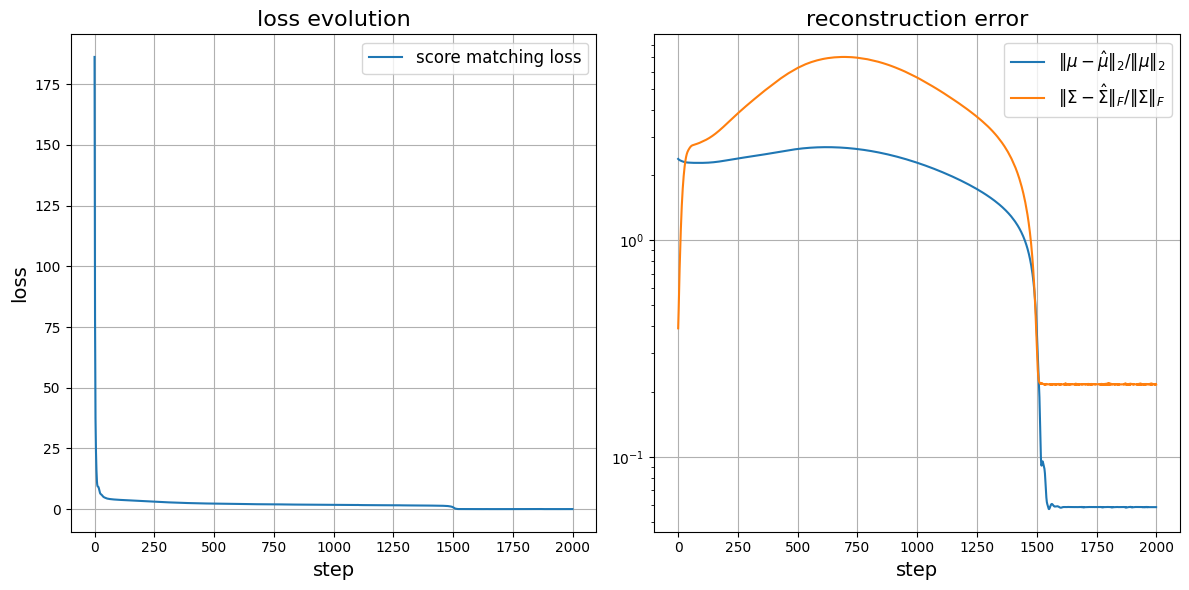

In [12]:
plt.figure(figsize=(12, 6))


plt.subplot(1, 2, 1)
plt.plot(history_np["loss"], label="score matching loss")
plt.xlabel("step", fontsize=14)
plt.ylabel("loss", fontsize=14)
plt.title("loss evolution", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.subplot(1, 2, 2)
plt.plot(history_np["mu_l2"]/np.linalg.norm(mu), label=r"$\| \mu - \hat{\mu} \|_2/\|\mu\|_2$")
plt.plot(history_np["cov_fro"]/np.linalg.norm(cov), label=r"$\| \Sigma - \hat{\Sigma} \|_F/\|\Sigma\|_F$")
plt.yscale("log")
plt.xlabel("step", fontsize=14)
plt.title("reconstruction error", fontsize=16)
plt.grid(True)
plt.legend(fontsize=12)


plt.tight_layout()
plt.show()

In [13]:
sample_sizes = np.arange(50, 2001, 50)
n_steps = 800


all_losses = []
all_mu_errors = []
all_cov_errors = []


for n in tqdm(sample_sizes):
    samples = generate_gaussian_samples(mu, cov, n, seed=0)
    _, _, history = lm_optimize_with_tracking(samples, mu, cov, n_epochs=n_steps, base_lr=0.1, seed = 0)
    all_losses.append(np.array(history["loss"]))
    all_mu_errors.append(np.array(history["mu_l2"]))
    all_cov_errors.append(np.array(history["cov_fro"]))

  0%|          | 0/40 [00:00<?, ?it/s]

epoch 0 | loss = 264.616180
epoch 1 | loss = 194.239258
epoch 2 | loss = 142.600342
epoch 3 | loss = 108.381180
epoch 4 | loss = 85.832443
epoch 5 | loss = 70.715950
epoch 6 | loss = 60.299332
epoch 7 | loss = 52.896828
epoch 8 | loss = 47.421124
epoch 9 | loss = 43.189560
epoch 10 | loss = 39.785290
epoch 11 | loss = 36.940292
epoch 12 | loss = 34.488792
epoch 13 | loss = 32.346653
epoch 14 | loss = 30.469229
epoch 15 | loss = 28.813618
epoch 16 | loss = 27.336178
epoch 17 | loss = 26.002012
epoch 18 | loss = 24.789619
epoch 19 | loss = 23.684841
epoch 20 | loss = 22.671562
epoch 21 | loss = 21.729668
epoch 22 | loss = 20.840693
epoch 23 | loss = 19.994862
epoch 24 | loss = 19.193733
epoch 25 | loss = 18.447071
epoch 26 | loss = 17.765284
epoch 27 | loss = 17.152006


  0%|          | 0/40 [00:06<?, ?it/s]

epoch 28 | loss = 16.601662


KeyboardInterrupt: 

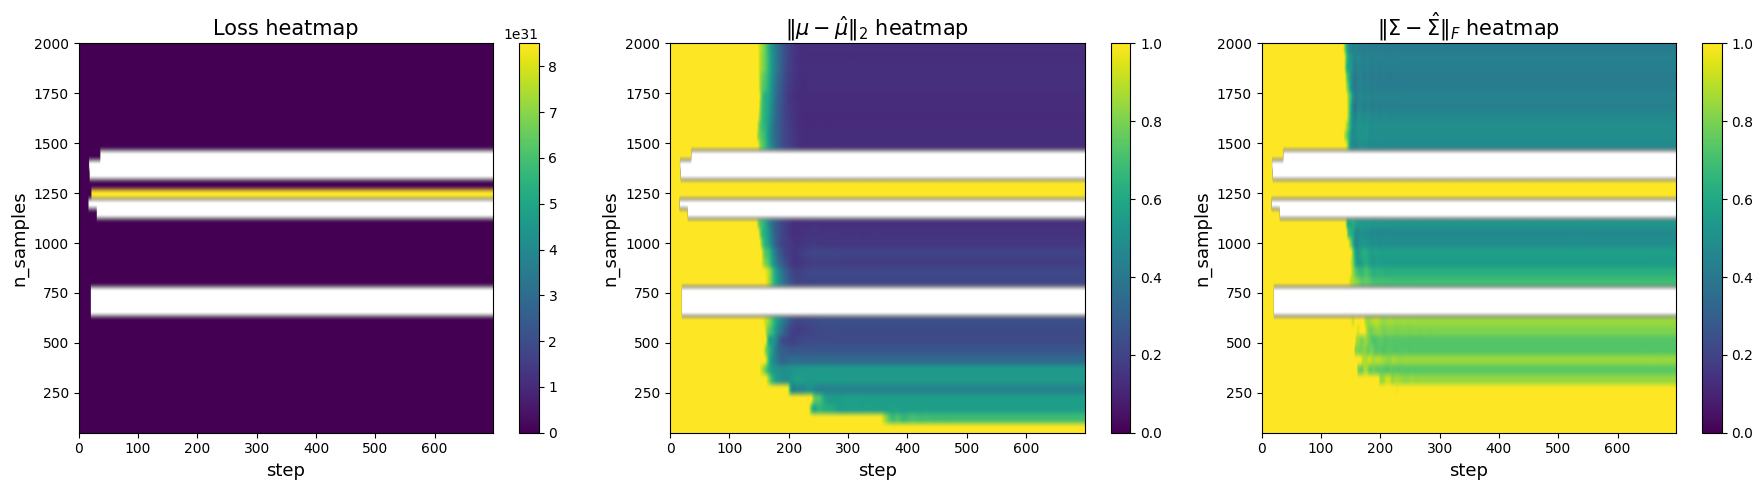

In [ ]:
loss_matrix = np.array(all_losses)
mu_err_matrix = np.array(all_mu_errors)/np.linalg.norm(mu)
cov_err_matrix = np.array(all_cov_errors)/np.linalg.norm(cov)


steps = np.linspace(0, n_steps, n_steps)
sample_sizes = np.arange(50, 2001, 50)


def plot_heatmap(data, title, ylabel, cmap="viridis", vmin=None, vmax=None):
    plt.imshow(data, aspect="auto", origin="lower", cmap=cmap,
               extent=[steps[0], steps[-1], sample_sizes[0], sample_sizes[-1]],
               vmin=vmin, vmax=vmax)
    plt.colorbar()
    plt.xlabel("step", fontsize=13)
    plt.ylabel("n_samples", fontsize=13)
    plt.title(title, fontsize=15)


plt.figure(figsize=(18, 5))


plt.subplot(1, 3, 1)
plot_heatmap(loss_matrix, "Loss heatmap", "n_samples")


plt.subplot(1, 3, 2)
plot_heatmap(mu_err_matrix, r"$\|\mu - \hat{\mu}\|_2/\|\mu\|_2$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.subplot(1, 3, 3)
plot_heatmap(cov_err_matrix, r"$\|\Sigma - \hat{\Sigma}\|_F/\|\Sigma\|_F$ heatmap", "n_samples", vmin=0.0, vmax=1.0)


plt.tight_layout()
plt.show()